In [7]:
import numpy as np
import cv2
from skimage import io
from skimage.util import img_as_ubyte
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

import matplotlib.pyplot as plt

from pathlib import Path
import json
import matplotlib.patches as patches
import time

In [8]:
# def save_image(image,addr,num):
#   address = addr + str(num)+ '.jpg'
#   cv2.imwrite(address,image)
  
# # 读取视频文件
# videoCapture = cv2.VideoCapture("./video/p2.mp4")
# # 通过摄像头的方式
# # videoCapture=cv2.VideoCapture(1)
  
# #读帧
# success, frame = videoCapture.read()
# print(frame.shape)
# plt.figure()
# plt.imshow(frame[:,:,::-1])
# i = 1
# save_image(frame,'./output/image',i)
# if success:
#     print('save image:',i)

(450, 800, 3)


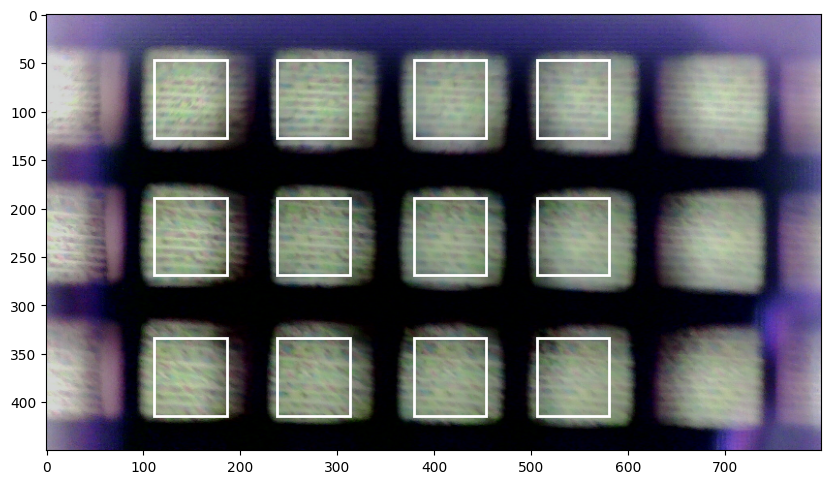

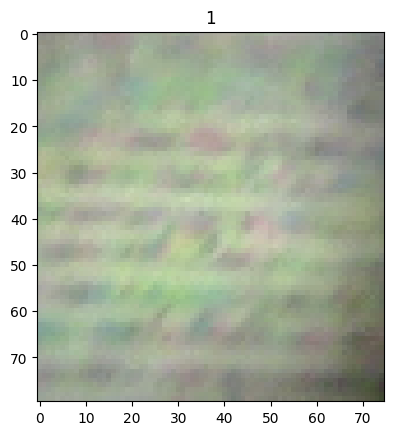

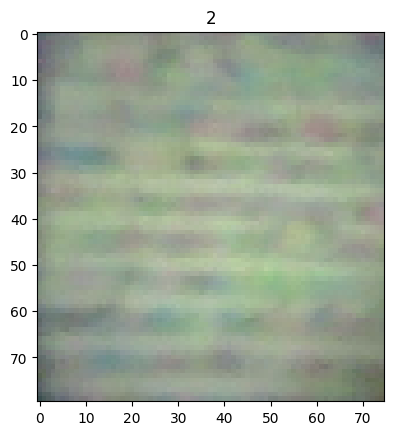

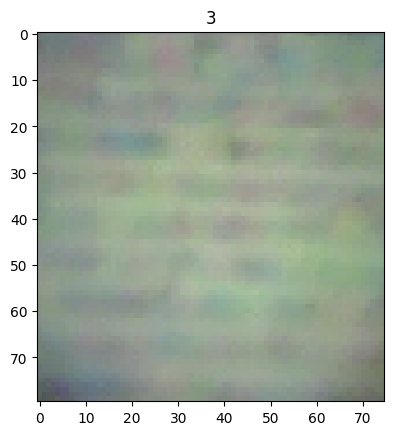

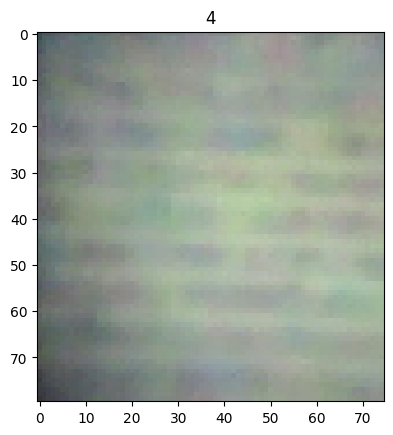

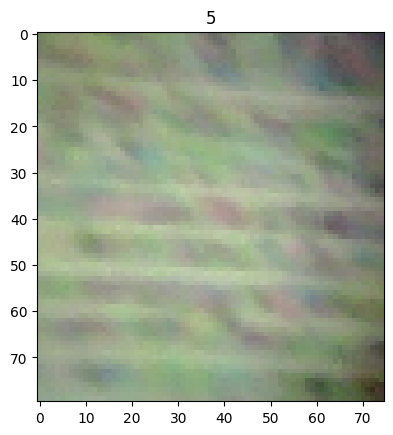

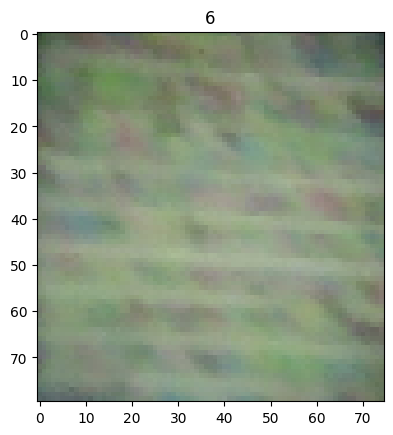

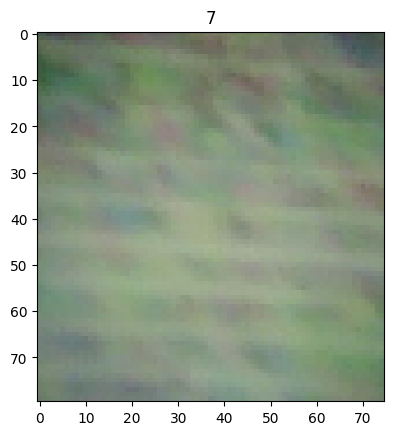

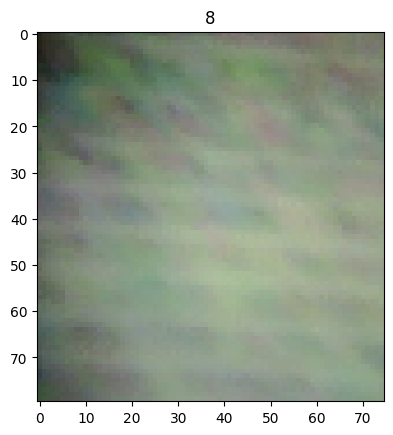

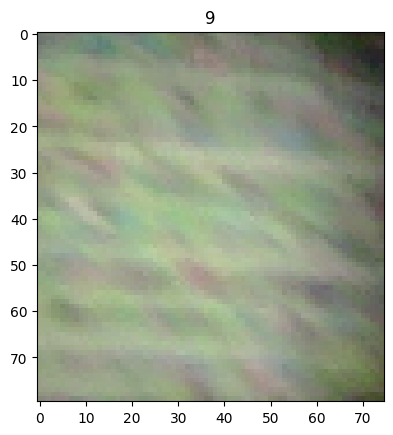

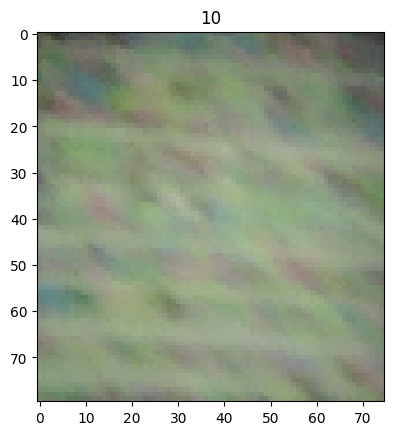

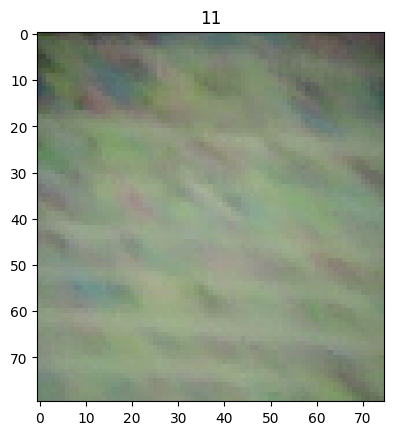

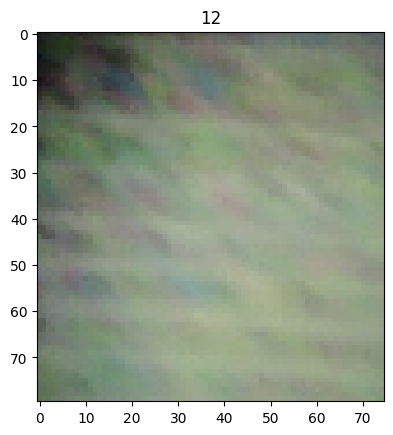

In [39]:
fig,ax = plt.subplots(figsize=(10,10))



with open('./config/rect_vertices_2_calib_samesize.json', 'r') as rect_file:
    rect = json.load(rect_file)

image = io.imread("2023-04-04-095628.jpg")
# print(image.shape)
image = cv2.resize(image, (800, 450))

print(image.shape)

#Re

# Display the image
ax.imshow(image, cmap='gray')
ax.axis('on')

i = 1
left_top1 = [0,0]
right_bottom1 = [0,0]

for vertice in rect['vertices']:
    left_top = rect['vertices'][vertice]['left_top']
    right_bottom = rect['vertices'][vertice]['right_bottom']

    hz = -55
    left_top1[0] = left_top[0] + hz
    right_bottom1[0] = right_bottom[0] + hz

    gsl = -5
    left_top1[1] = left_top[1] + gsl
    right_bottom1[1] = right_bottom[1] + gsl

    
    # Create a Rectangle patch
    rect_patch = patches.Rectangle((left_top1[0],left_top1[1]),
                             right_bottom1[0]-left_top1[0],right_bottom1[1] - left_top1[1],
                             linewidth=2, edgecolor='w',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect_patch)

    # cut roi tiles and save
#     print(left_top[0])
    img_tile = image[int(left_top1[1]):int(right_bottom1[1]), int(left_top1[0]):int(right_bottom1[0]), :]
    plt.figure()
    plt.title(i)
    plt.imshow(img_tile)
#     plt.imshow(cv2.flip(img_tile, -1))
    i = i + 1


C:\Users\lluoan\AppData\Local\Temp\ipykernel_31212\363829620.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if hstack == []:
C:\Users\lluoan\AppData\Local\Temp\ipykernel_31212\363829620.py:34: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if vstack == []:


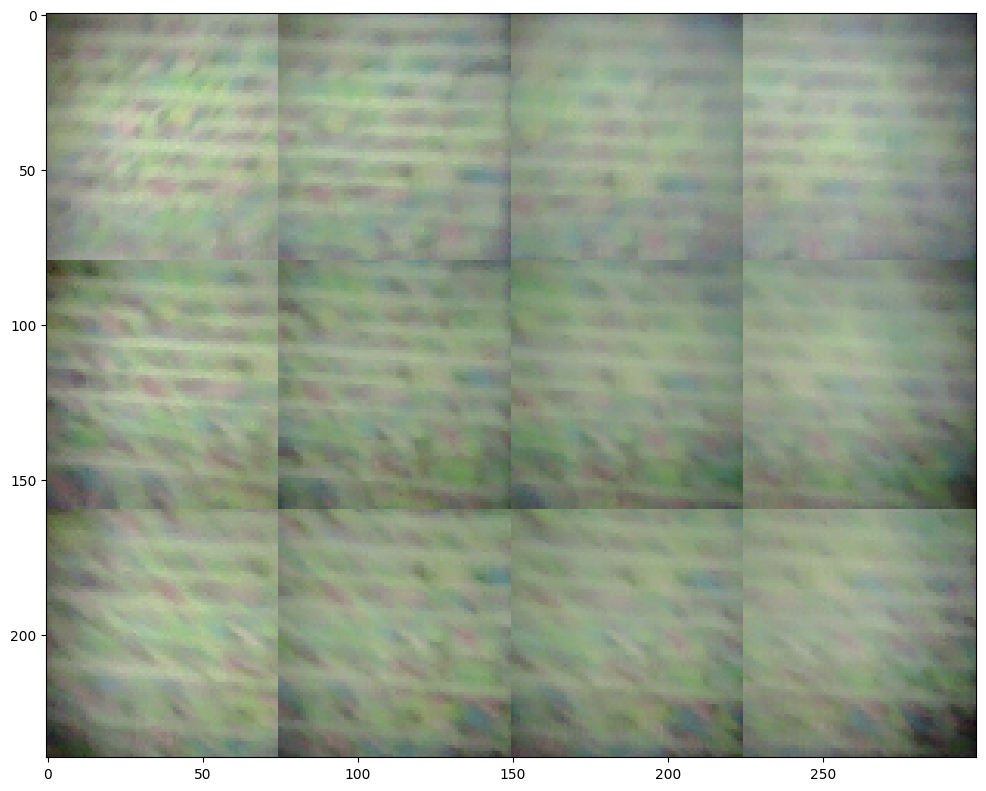

In [40]:
ncol = 4
nrow = 3

vstack = []
tile_list = []

left_top1 = [0,0]
right_bottom1 = [0,0]

for i in range(nrow):
    hstack = []
    for j in range(ncol):
        key = 'vertice{}'.format(i*ncol + j+1)
        left_top = rect['vertices'][key]['left_top']
        right_bottom = rect['vertices'][key]['right_bottom']

        hz = -55
        left_top1[0] = left_top[0] + hz
        right_bottom1[0] = right_bottom[0] + hz

        gsl = -5
        left_top1[1] = left_top[1] + gsl
        right_bottom1[1] = right_bottom[1] + gsl

        tile = image[int(left_top1[1]):int(right_bottom1[1]),
                    int(left_top1[0]):int(right_bottom1[0]), :]
        tile_flipped = cv2.flip(tile, -1)
        
        tile_list.append(tile_flipped)
        if hstack == []:
            hstack = tile_flipped
        else:
            hstack = np.hstack((hstack, tile_flipped))
    if vstack == []:
        vstack = hstack
    else:
        vstack = np.vstack((vstack, hstack))

plt.figure(figsize=(12,12))
plt.imshow(vstack, cmap='gray')


(80, 75, 3) (80, 75, 3)


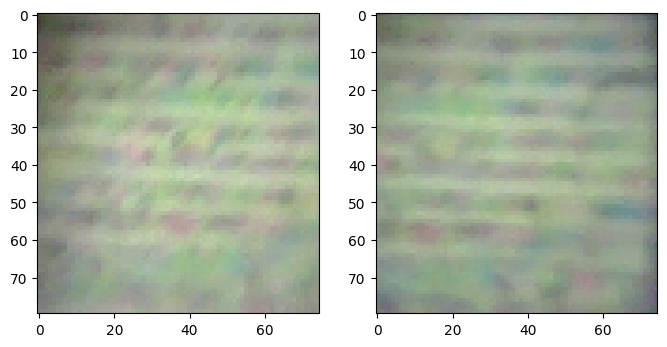

In [54]:
from skimage.color import rgb2gray, rgb2hsv, hsv2rgb
# img1 = rgb2gray(tile_list[0])
# img2 = rgb2gray(tile_list[1])
# img1 = rgb2hsv(tile_list[0])
# img2 = rgb2hsv(tile_list[4])
img1 = tile_list[0]
img2 = tile_list[1]
# img1 = img1.astype(np.float32)
# img2 = img2.astype(np.float32)
# scale image brightness
# img2[:,:, 2] = img2[:,:, 2]*1.1

# img1 = hsv2rgb(img1)*255
# img2 = hsv2rgb(img2)*255

fig, ax = plt.subplots(1,2, figsize=(8, 5))
ax = ax.ravel()

ax[0].imshow(img1[:,:, :].astype(np.uint8), cmap='gray')
ax[1].imshow(img2[:,:, :].astype(np.uint8), cmap='gray')
print(img1.shape, img2.shape)

In [12]:
print(cv2.__version__)

4.6.0


In [55]:
# ol_w = [6,8,7,9,5,7,6] ground truth
# assume that the overlapping is around 10% of roi size
dim = 1
nominal_ov_pos = 40
bound = 39 # +- bounds around nominal_ov_pos

ov_position = [i for i in range(nominal_ov_pos - bound, nominal_ov_pos+bound+1)]

def find_ov(img1, img2, nominal_ov, bound_ov, dim=1):
    '''
        default dimension is along axis 1 (width of the images)
    '''
    cross_corr = []
    tested_ov = range(nominal_ov - bound_ov, nominal_ov+bound_ov + 1)
    for ov in tested_ov:
        if dim == 1:
            ov_area1 = img1[:, -ov:,:]
            ov_area2 = img2[:,  :ov,:]
        elif dim == 0:
            ov_area1 = img1[-ov:, :,:]
            ov_area2 = img2[:ov,  :,:]
#         print(ov_area1.shape)
#         print(ov_area2.shape)
#         print(ov_area1[:,:,2].shape)
#         a = ov_area1[:,:,i]/1.0
#         b = ov_area2[:,:, i]/1.0
# #         print(a.shape, b.shape)
# #         print(a,b)
#         corr = np.sum(np.multiply(a, b))/(np.sqrt(np.sum(a**2)) * np.sqrt(np.sum(b**2)))
        # multi-channel cross correlation
        corr = 0.0
#         print(ov_area1.shape)
        for i in range(3):
            a = ov_area1[:,:,i]/1.0
            b = ov_area2[:,:, i]/1.0
            corr = corr + np.sum(np.multiply(a, b)) / np.sqrt(np.sum(a**2) * np.sum(b**2))
        corr = corr/3.0
#         print(corr)
        # rgb color distance -> minimize
#         print(np.sum(np.square(img1[:, -(ov+1), :] - img2[:, 0, :])) + np.sum(np.square(img1[:,-1,:] - img2[:, ov]) ))
        cross_corr.append(corr)
#         print(corr)
#         print('---')
        
#     print(cross_corr)
    ov_pos = tested_ov[np.argmax(cross_corr)]
    print(max(cross_corr))
    if dim == 1:
        ov_1 = img1[:, -ov_pos:, :]
        ov_2 = img2[:,  :ov_pos, :]
    elif dim == 0:
        ov_1 = img1[-ov_pos:, :, :]
        ov_2 = img2[:ov_pos,  :, :]
    
    return ov_pos, ov_1, ov_2, cross_corr

def find_ov_hsv(img1, img2, nominal_ov, bound_ov, dim=1):
    '''
        default dimension is along axis 1 (width of the images)
    '''
    img1_hsv = cv2.cvtColor(img1.copy(), cv2.COLOR_RGB2HSV)
    img2_hsv = cv2.cvtColor(img2.copy(), cv2.COLOR_RGB2HSV)
    
    cross_corr = []
    tested_ov = range(nominal_ov - bound_ov, nominal_ov+bound_ov + 1)
    for ov in tested_ov:
        if dim == 1:
            ov_area1 = img1_hsv[:, -ov:,:]
            ov_area2 = img2_hsv[:,  :ov,:]
        elif dim == 0:
            ov_area1 = img1_hsv[-ov:, :,:]
            ov_area2 = img2_hsv[:ov,  :,:]
#         print(ov_area1.shape)
#         print(ov_area2.shape)
#         print(ov_area1[:,:,2].shape)
#         a = ov_area1[:,:,i]/1.0
#         b = ov_area2[:,:, i]/1.0
# #         print(a.shape, b.shape)
# #         print(a,b)
#         corr = np.sum(np.multiply(a, b))/(np.sqrt(np.sum(a**2)) * np.sqrt(np.sum(b**2)))
        # multi-channel cross correlation
        corr = 0.0
#         print(ov_area1.shape)
        for i in range(2):
            a = ov_area1[:,:, i]
            b = ov_area2[:,:, i]
            corr = corr + np.sum(np.multiply(a, b)) / np.sqrt(np.sum(a**2) * np.sum(b**2))
        corr = corr/2.0
#         print(corr)
        # rgb color distance -> minimize
#         print(np.sum(np.square(img1[:, -(ov+1), :] - img2[:, 0, :])) + np.sum(np.square(img1[:,-1,:] - img2[:, ov]) ))
        cross_corr.append(corr)
#         print(corr)
#         print('---')
        
#     print(cross_corr)
    ov_pos = tested_ov[np.argmax(cross_corr)]
    if dim == 1:
        ov_1 = img1[:, -ov_pos:, :]
        ov_2 = img2[:,  :ov_pos, :]
    elif dim == 0:
        ov_1 = img1[-ov_pos:, :, :]
        ov_2 = img2[:ov_pos,  :, :]
    
    return ov_pos, ov_1, ov_2, cross_corr


img1 = img1.astype(np.float32)
img2 = img2.astype(np.float32)
t1 = time.time()
ov_pos, ov1, ov2, cross_corr = find_ov(img1, img2, nominal_ov_pos, bound, dim=dim)
print(ov_pos)
print(time.time() - t1)
print(cross_corr)

0.9966889023780823
51
0.009998083114624023
[0.9939569036165873, 0.9942019581794739, 0.9944387276967367, 0.9946834246317545, 0.9949321945508321, 0.9951486587524414, 0.9952282706896464, 0.9951761960983276, 0.9950596888860067, 0.9949609438578287, 0.9949015974998474, 0.9949131806691488, 0.994946300983429, 0.9950224955876669, 0.9950322111447653, 0.9950806101163229, 0.9951155781745911, 0.995118776957194, 0.99512646595637, 0.995080828666687, 0.9950338204701742, 0.9949979980786642, 0.9949959317843119, 0.9950039784113566, 0.995012084643046, 0.9950511654218038, 0.9951160748799642, 0.9951784809430441, 0.9952035347620646, 0.9952113032341003, 0.9952060977617899, 0.9952086408933004, 0.9951991240183512, 0.9952270189921061, 0.9952393571535746, 0.995233436425527, 0.9952176411946615, 0.9951974550882975, 0.9951791763305664, 0.9951606392860413, 0.9951541622479757, 0.9951845208803812, 0.9952906568845113, 0.9954740405082703, 0.995677630106608, 0.9959110816319784, 0.9961587190628052, 0.9963866670926412, 0.99

51 0.9966889023780823


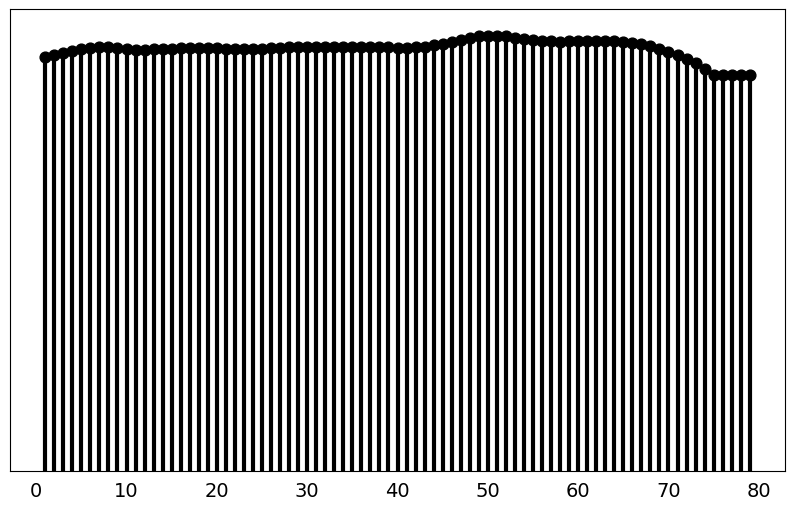

In [56]:
%matplotlib inline
from matplotlib import collections as matcoll
print(ov_position[int(np.where(cross_corr==np.max(cross_corr))[0])], max(cross_corr))

# ov_position = [3, 4, 5, 6, 7, 8, 9, 10, 11]
# corr = [0.9909849265735179, 0.996767876208091, 0.999480813538509, 0.9965571362709759, 0.9890487794768316, 
#         0.9807278651316307, 0.9727282861279635, 0.9648033317627641, 0.9573152509152888]

# ov_position = range(37 - 10, 37+10+1)

lines = []
for i in range(len(ov_position)):
    pair=[(ov_position[i],0.0), (ov_position[i], cross_corr[i])]
    lines.append(pair)
    
linecoll = matcoll.LineCollection(lines, color='k', linewidths=3)
fig, ax = plt.subplots(figsize=(10,6))
ax.add_collection(linecoll)

# plt.figure()
plt.scatter(ov_position, cross_corr, c='k', s=60)
plt.ylim(min(cross_corr)-0.05, 1)
# plt.xlabel('Overlapping position')
# plt.ylabel('Cross correlation')

plt.tick_params(bottom=False, labelleft=False, left=False, labelsize=14)

54
(80, 75, 3) (80, 75, 3)


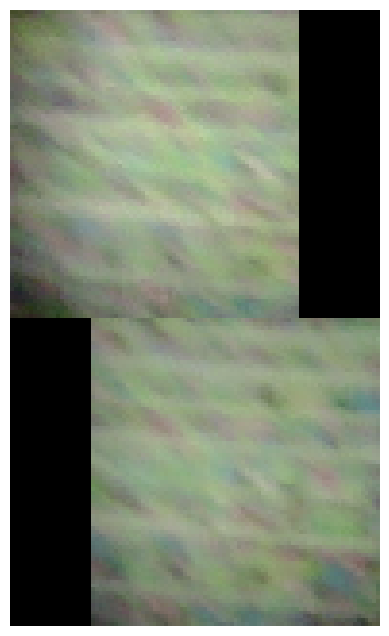

In [50]:
# import copy
def stitch(img1, img2, ov_pos, ov1, ov2, blend=True, dim=1):
#     ov_avg = (ov1/2+ov2/2).astype('uint8')
    
    t1 = time.time()
    if blend:
        # linear blending
        ov1_blended = ov1.copy()
        ov2_blended = ov2.copy()
        for i in range(ov_pos):
            blend_coef = -(1/(ov_pos-1))*i + 1
            if dim==1:
                ov1_blended[:,i,:] = ov1[:,i,:]*blend_coef
                ov2_blended[:,i,:] = ov2[:,i,:]*(1.-blend_coef)
            elif dim==0:
                ov1_blended[i, :,:] = ov1[i, :,:]*blend_coef
                ov2_blended[i, :,:] = ov2[i, :,:]*(1.-blend_coef)
        ov_blended = ov1_blended + ov2_blended
        ov = ov_blended
    else:
        ov = ov1
#     print('time: linear blending >>>', time.time() - t1)
    
    if dim == 1:
        stitched_img = np.concatenate((img1[:, :-ov_pos, :], ov, img2[:, ov_pos: :]), axis = 1)
    elif dim == 0:
        stitched_img = np.concatenate((img1[:-ov_pos, :, :], ov, img2[ov_pos:, :, :]), axis = 0)
    
    return stitched_img

def image_alignment(img1, img2, ov_pos, dim=1):
    print(img1.shape, img2.shape)
    height, width1, _ = img1.shape
    _, width2, _ = img2.shape
    if dim == 1:
        blank1 = np.zeros([height, width2-ov_pos, 3]).astype('uint8')
        align_1 = np.concatenate((img1, blank1), axis=1)
        blank2 = np.zeros([height, width1-ov_pos, 3]).astype('uint8')
        align_2 = np.concatenate((blank2, img2), axis=1)
#         print(align_2.shape)
        align_img = np.concatenate((align_1, align_2), axis=0)
    return align_img
        
# 
# ov_pos = 55
plt.figure(figsize=(10, 8))
plt.axis('off')
# print(img1)
print(ov_pos)
# stitched_img = stitch(img1, img2, ov_pos, ov1, ov2, blend=1, dim=dim)
stitched_img = image_alignment(img1, img2, ov_pos, dim=1)
plt.imshow(stitched_img.astype(np.uint8), cmap='gray')

0
0.9967619944712506
0th overlap size in row 0:  50
0.9965083956182893
1th overlap size in row 0:  73
0.9982061782987648
2th overlap size in row 0:  51
Stitched row  width >>>   126
1
0.9955775181222396
0th overlap size in row 1:  52
0.9973384883629478
1th overlap size in row 1:  66
0.9981057858097492
2th overlap size in row 1:  53
Stitched row  width >>>   129
1 -3
0.9962538594182327
Row overlapping: 64
2
0.9975203101148559
0th overlap size in row 2:  54
0.9976000311572126
1th overlap size in row 2:  68
0.9986987465042884
2th overlap size in row 2:  55
Stitched row  width >>>   123
2 3
0.9953383120407117
Row overlapping: 74
Time elapsed:  0.07602977752685547
[['hor 0', 50], ['hor 1', 73], ['hor 2', 51], ['ver 0', 0], ['hor 0', 52], ['hor 1', 66], ['hor 2', 53], ['ver 1', 64], ['hor 0', 54], ['hor 1', 68], ['hor 2', 55], ['ver 2', 74]]
(102, 126, 3)


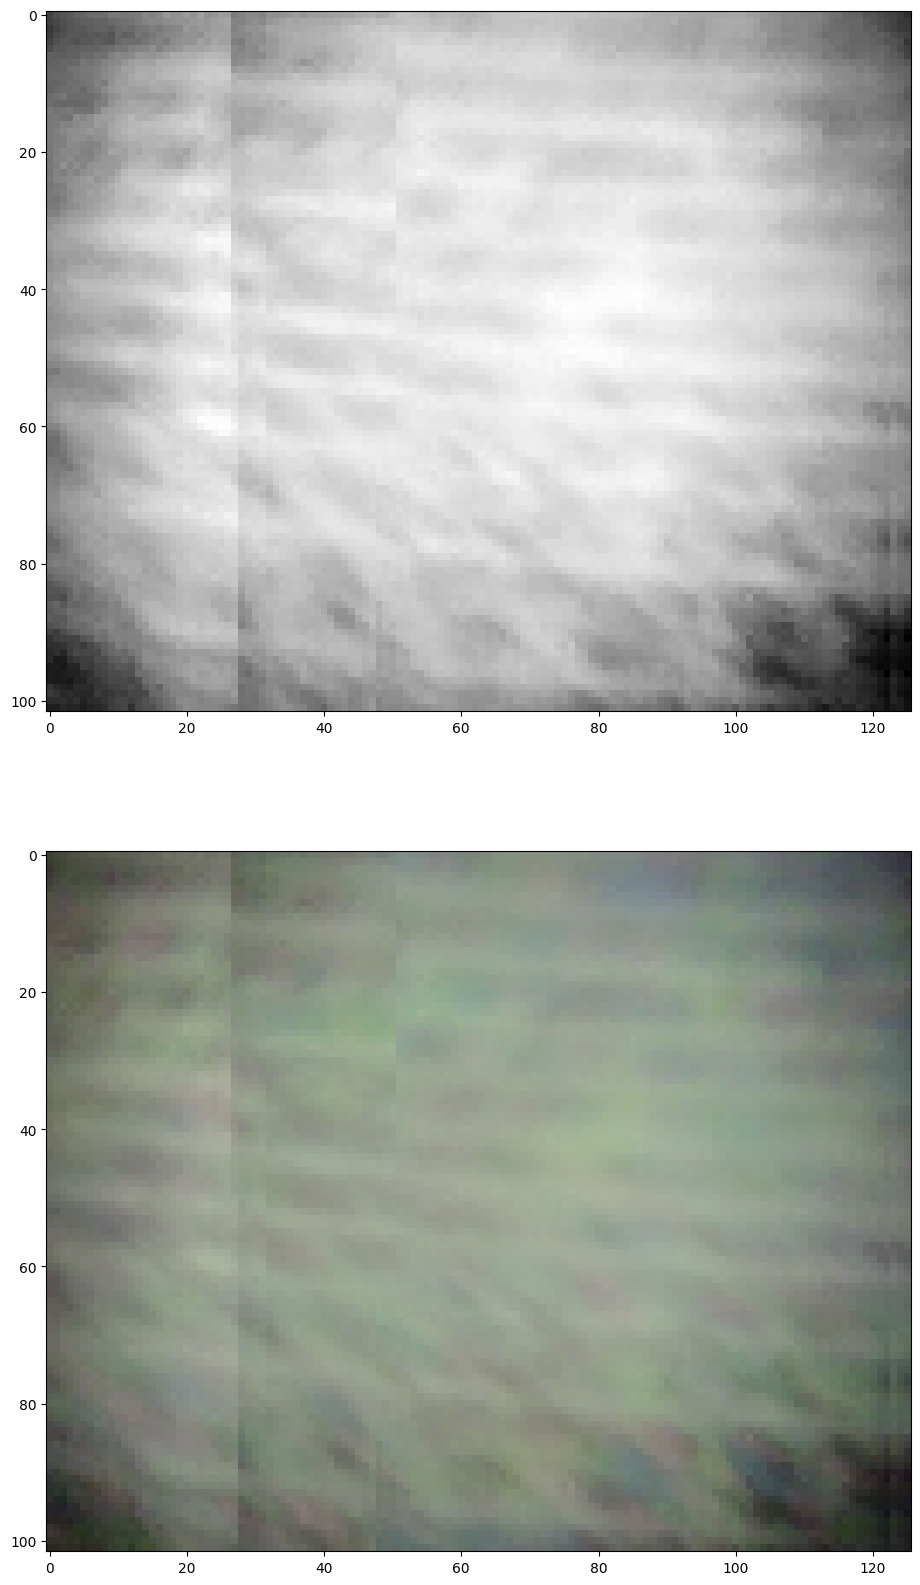

In [53]:
import time

def save_image(image,addr,num):
    address = addr + str(num)+ '.jpg'
    cv2.imwrite(address,image)
    
# print(range(2))
t1 = time.time()
img_stitched_height = None
change_sv = 1
s_mean = 28.0
v_mean = 150.0

stitch_calibration = []

for i in range(nrow):
# for i in range(3,4):
    img_stitched_width = None
    print(i)
    for j in range(ncol):
#         if i == 0 && j == 0:
        if j == 0:
            if change_sv == False: 
                img_j0 = tile_list[i*4]
            
            else:
                img_j0 = cv2.cvtColor(tile_list[i*4], cv2.COLOR_RGB2HSV)
                img_j0 = img_j0.astype(np.float64)
#                 print("b",img_j0.dtype)
                img_j0[:,:,1] = np.clip(img_j0[:,:,1] * s_mean / np.mean(img_j0[:,:,1]),0.0,255.0)
                img_j0[:,:,2] = np.clip(img_j0[:,:,2] * v_mean / np.mean(img_j0[:,:,2]),0.0,255.0)
                img_j0 = cv2.cvtColor(img_j0.astype(np.uint8), cv2.COLOR_HSV2RGB)
#                 print(img_j0.dtype)

            img_stitched_width = img_j0
#             img_stitched_width = tile_list_histMatched[i*4+j]
        else:
#             print(i*4 + j-1)
            if change_sv == False: 
                img_1 =  tile_list[i*4 + j-1]#tile_list_histMatched[i*4 + j-1]
                img_2 =  tile_list[i*4 + j] #tile_list_histMatched[i*4 + j]
            
            else:
                img_1 = cv2.cvtColor(tile_list[i*4 + j-1], cv2.COLOR_RGB2HSV)
                img_1 = img_1.astype(np.float64)
                img_1[:,:,1] = np.clip(img_1[:,:,1] * s_mean / np.mean(img_1[:,:,1]),0,255)
                img_1[:,:,2] = np.clip(img_1[:,:,2] * v_mean / np.mean(img_1[:,:,2]),0,255)
                img_1 = cv2.cvtColor(img_1.astype(np.uint8), cv2.COLOR_HSV2RGB)

                img_2 = cv2.cvtColor(tile_list[i*4 + j], cv2.COLOR_RGB2HSV)
                img_2 = img_2.astype(np.float64)
                img_2[:,:,1] = np.clip(img_2[:,:,1] * s_mean / np.mean(img_2[:,:,1]),0,255)
                img_2[:,:,2] = np.clip(img_2[:,:,2] * v_mean / np.mean(img_2[:,:,2]),0,255)
                img_2 = cv2.cvtColor(img_2.astype(np.uint8), cv2.COLOR_HSV2RGB)
            
            
#             print(img1.shape, img2.shape)
#             time.sleep(0.1)
#             plt.figure()
#             plt.subplot(1,2,1)
#             plt.imshow(img1)
#             plt.axis('off')
#             plt.subplot(1,2,2)
#             plt.imshow(img2)
#             plt.axis('off')
            
            ov_pos, ov1, ov2, c_corr = find_ov(img_1, img_2, nominal_ov=60, bound_ov=20, dim=1)
            print('{}th overlap size in row {}: '.format(j-1, i), ov_pos)
            
            stitch_calibration.append(["hor {}".format(j-1),ov_pos])

            
            # stitch images with stacking
            img_stitched_width = stitch(img_stitched_width, img_2, ov_pos, ov1, ov2, blend=True, dim=1)
#             print(ov_pos)
        
#     plt.figure(figsize=(10, 3))
#     plt.subplot(1,2,1)
#     plt.imshow(img_stitched_width, cmap='gray')
#     plt.axis('off')
#     plt.subplot(1,2,2)
#     plt.imshow(img2)
#     plt.axis('off')
#     print('-----')
    print('Stitched row  width >>>  ', img_stitched_width.shape[1])
    if i == 0:
        img_stitched_height = img_stitched_width
        stitch_calibration.append(["ver {}".format(i),0])
        pass
    else:
        width = img_stitched_height.shape[1]
        width_new = img_stitched_width.shape[1]
        wdiff = width - width_new
        print(i, wdiff)
        if wdiff > 0:
            img_stitched_width = np.hstack((img_stitched_width, img_stitched_width[:, -wdiff:]))
        elif wdiff < 0:
            img_stitched_width = img_stitched_width[:, :wdiff]
#         print(img_stitched_height.shape[1], img_stitched_width.shape[1])
        
        ov_pos_h, ov_h1, ov_h2, c_corr = find_ov(img_stitched_height, img_stitched_width, 
                                         nominal_ov=60, bound_ov=20, dim=0)
        stitch_calibration.append(["ver {}".format(i),ov_pos_h])
        
        print('Row overlapping:', ov_pos_h)
        img_stitched_height = stitch(img_stitched_height, img_stitched_width, 
                                     ov_pos_h, ov_h1, ov_h2, blend=True, dim=0)
t = time.time() - t1
print('Time elapsed: ', t)
%matplotlib inline

plt.figure(figsize=(12, 20))
plt.subplot(2,1,1)
plt.imshow(cv2.cvtColor(img_stitched_height,cv2.COLOR_RGB2GRAY), cmap='gray')
plt.subplot(2,1,2)
plt.imshow(img_stitched_height, cmap='gray')
# plt.axis('off')
print(stitch_calibration)

# np.save("./config/stitch_calibration.npy", np.asarray(stitch_calibration)) 

print(img_stitched_height.shape)

In [342]:
a = np.asarray([1,2,3,4.6,255,257], dtype=np.uint8)
b = np.asarray(["a"])
print(b)
print(a)

['a']
[  1   2   3   4 255   1]


In [343]:
import numba as nb
import time
# for each row/column, calculate all correlation map first

def np_generate_corr_map(img_list, nominal_ov, bound_ov, dim=1):
    corr_map = []
    for ind in range(len(img_list)-1):
        img1 = img_list[ind]
        img2 = img_list[ind+1]
        
        cross_corr = []
        range_ov = range(nominal_ov - bound_ov, nominal_ov+bound_ov + 1)
        for ov in range_ov:
            if dim == 1:
                ov_area1 = img1[:, -ov:, :]
                ov_area2 = img2[:,  :ov, :]
            elif dim == 0:
                ov_area1 = img1[-ov:, :, :]
                ov_area2 = img2[:ov,  :, :]
                
            corr = 0.0
    #         print(ov_area1.shape)
            for i in range(3):
                a = ov_area1[:,:,i]/1.0
                b = ov_area2[:,:, i]/1.0
                corr = corr + np.sum(np.multiply(a, b)) / np.sqrt(np.sum(a**2) * np.sum(b**2))
#                 corr += correlation_comp(a, b)
            corr = corr/3.0
    #         print(corr)
            cross_corr.append(corr)
        corr_map.append(cross_corr)
    return corr_map

# ============== test numba acceleration =================
import numexpr as ne

img_array = np.array(tile_list)*1.0
print(img_array.shape)
# @nb.njit
def nb_generate_corr_map(img_list, nominal_ov, bound_ov, dim=1):
    range_ov = range(nominal_ov - bound_ov, nominal_ov+bound_ov + 1)
    corr_map = np.zeros((img_list.shape[0]-1, len(range_ov)), dtype=np.double)
#     corr_map = np.zeros((12, 12), dtype=np.double)
    for ind in range(img_list.shape[0]-1):
        img1 = img_list[ind]
        img2 = img_list[ind+1]
        
        cross_corr = np.zeros((bound_ov*2+1), dtype=np.double)
        
        for i, ov in enumerate(range_ov):
            if dim == 1:
                ov_area1 = img1[:, -ov:, :]
                ov_area2 = img2[:,  :ov, :]
            elif dim == 0:
                ov_area1 = img1[-ov:, :, :]
                ov_area2 = img2[:ov,  :, :]
                
            corr = 0.0
    #         print(ov_area1.shape)
            for l in range(3):
                a = ov_area1[:,:,l]
                b = ov_area2[:,:, l]
                corr = corr + np.sum(np.multiply(a, b)) / \
                        np.sqrt(np.sum(np.square(a)) * np.sum(np.square(b)))
#             tmp = np.sum(np.multiply(ov_area1, ov_area2), axis=(0,1)) / \
#                 np.sqrt(np.sum(np.square(ov_area1), axis=(0,1)) * \
#                         np.sum(np.square(ov_area2), axis=(0,1)))
            corr = corr/3.0
#             corr = tmp.mean()
    #         print(corr)
            cross_corr[i] = corr
        corr_map[ind] = cross_corr
    return corr_map


# import cy_accel_functions.accel_utils as cy_accel


nominal_ov = 50
bound_ov = 15

img_array = img_array*1.0

print(img_array[4:8].dtype)

t1 = time.time()
print(img_array[0:4].shape)
# nb_generate_corr_map(img_array[0])
row_corr_map = nb_generate_corr_map(img_array[0:4], nominal_ov, bound_ov, dim=1)
# row_corr_map = cy_accel.cy_generate_corr_map(img_array[4:8], nominal_ov, bound_ov, dim=1)
# row_corr_map = np_generate_corr_map(tile_list[0:4], nominal_ov, bound_ov, dim=1)
print('cross correlation computation time: ', time.time() - t1)
print("Correlation map: ")
print(row_corr_map)
range_ov = np.arange(nominal_ov - bound_ov, nominal_ov+bound_ov + 1)
print(range_ov)

from pulp import *
import gurobipy
# solver_list = listSolvers(onlyAvailable=True)
# print(solver_list)
solver = getSolver('GUROBI')

prob = LpProblem("The constrained overlapping selection",LpMaximize)

n = len(row_corr_map[0])
N = range(n)
choose_vars_ov1 = LpVariable.dicts("ov1_choose_%s", N, 0, 1, cat="Integer")
# print(choose_vars_ov1)
choose_vars_ov2 = LpVariable.dicts("ov2_choose_%s", N, 0, 1, cat="Integer")
choose_vars_ov3 = LpVariable.dicts("ov3_choose_%s", N, 0, 1, cat="Integer")

chosen_value_ov1 = LpVariable("ov1_choosen")
chosen_value_ov2 = LpVariable("ov2_choosen")
chosen_value_ov3 = LpVariable("ov3_choosen")


prob += (chosen_value_ov1+chosen_value_ov2+chosen_value_ov3), "target function"

prob += chosen_value_ov1 == lpSum([row_corr_map[0][i] * choose_vars_ov1[i] for i in N]), "chosen_value computation"
prob += lpSum([choose_vars_ov1[i] for i in N]) == 1, "Enforcing only one entry of variable equals to 1"
prob += chosen_value_ov2 == lpSum([row_corr_map[1][i] * choose_vars_ov2[i] for i in N])
prob += lpSum([choose_vars_ov2[i] for i in N]) == 1
prob += chosen_value_ov3 == lpSum([row_corr_map[2][i] * choose_vars_ov3[i] for i in N])
prob += lpSum([choose_vars_ov3[i] for i in N]) == 1
prob += lpSum([range_ov[i]*(choose_vars_ov1[i] + choose_vars_ov2[i] + 
                           choose_vars_ov3[i]) for i in N]) == 150, "fixed stitching size constraint"
# t1 = time.time()
start = time.time()
prob.solve(solver)
# prob.solve(solvers.CPLEX())
print("problem solving time: ", time.time() - start)
choose_vars_soln = []
choose_vars_soln.append([choose_vars_ov1[i].varValue for i in N])
choose_vars_soln.append([choose_vars_ov2[i].varValue for i in N])
choose_vars_soln.append([choose_vars_ov3[i].varValue for i in N])




# print(choose_vars_soln)

print('overlapping sizes: ')
print(range_ov[np.nonzero(choose_vars_soln[0])[0]])
print(range_ov[np.nonzero(choose_vars_soln[1])[0]])
print(range_ov[np.nonzero(choose_vars_soln[2])[0]])

(12, 80, 75, 3)
float64
(4, 80, 75, 3)
cross correlation computation time:  0.01552891731262207
Correlation map: 
[[0.97232303 0.97360273 0.97440233 0.97442321 0.97383534 0.97344401
  0.97368326 0.97432786 0.97499248 0.97585643 0.97706786 0.97895893
  0.9819185  0.98597744 0.98982921 0.99166815 0.98978949 0.98646965
  0.9839113  0.98190197 0.98065634 0.97952863 0.9788189  0.97835178
  0.97771893 0.97671185 0.97588807 0.97545714 0.97496226 0.97399158
  0.97279376]
 [0.93913501 0.9391279  0.93949576 0.94034413 0.94107844 0.94190578
  0.94285806 0.94411471 0.94514614 0.94575815 0.94665467 0.9472324
  0.94803899 0.94940484 0.95031096 0.95093574 0.95172395 0.95266873
  0.9534111  0.95440284 0.9559507  0.95763823 0.95885517 0.96007023
  0.96250741 0.96640865 0.97098419 0.97597523 0.97983365 0.98021242
  0.97663809]
 [0.97032077 0.97039748 0.9706105  0.9705112  0.97030645 0.97004289
  0.96989045 0.96955513 0.96951003 0.97046449 0.97292959 0.9760374
  0.97884585 0.9807033  0.98096817 0.9790187

C:\Users\gzhangaq\Anaconda3\envs\py3\lib\site-packages\pulp\pulp.py:1199: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [178]:
# all images stitching
corr_map = np.empty([nrow, ncol-1, bound_ov*2+1])
t１= time.time()
for i in range(nrow):
#     print(i)
    image_array = img_array[i*ncol: i*ncol + ncol]
    corr_map[i] = nb_generate_corr_map(image_array, nominal_ov, bound_ov, dim=1)
print(time.time()-t1)
print(corr_map)

rows = [1,2,3]
cols = [1,2,3]
print('n = ', n)
N = range(n)
choose_vars = LpVariable.dicts('choose', (rows, cols, N), 0, 1, cat="Integer")
chosen_values = LpVariable.dicts('chosen_val', (rows, cols), cat="Continuous")
# print(choose_vars)
# print(chosen_values)
prob1 = LpProblem('opt 3 together', LpMaximize)
# print(lpSum([chosen_values[i][j] for i in rows for j in cols]))
prob1 += lpSum([chosen_values[i][j] for i in rows for j in cols]), "cost function"

# assign chosen_values
# print(chosen_values[1][3])
# print(corr_map[1, 3, 3])
# print(choose_vars[1][3][3])
# print(choose_vars[1][1])
# print(range_ov[0])
for i in rows:
    for j in cols:
#         print(chosen_values[i][j] == lpSum([corr_map[i-1, j-1, k]*choose_vars[i][j][k] for k in N]))
#         print('---------------------------')
        prob1 += chosen_values[i][j] == lpSum([corr_map[i-1, j-1, k]*choose_vars[i][j][k] for k in N])
        prob1 += lpSum([choose_vars[i][j][k] for k in N]) == 1
#     print(i)    
    prob1 += lpSum([range_ov[l]*choose_vars[i][k][l] for k in cols for l in N]) == 150
t1 = time.time()
prob1.solve(solver)
print(time.time()-t1)

chosen_sol = np.empty([nrow, ncol-1])
for i in rows:
    for j in cols:
#         print(np.nonzero([choose_vars[i][j][l].varValue for l in N])[0] )
        
        chosen_sol[i-1, j-1] = range_ov[np.nonzero([choose_vars[i][j][l].varValue for l in N])[0] ]
print('overlapping sizes for rows: ')
print(chosen_sol)

# saving overlap sizes
ov_dict ={}
ov_dict['inter_cols'] = chosen_sol.tolist()

0.046558380126953125
[[[0.97232303 0.97360273 0.97440233 0.97442321 0.97383534 0.97344401
   0.97368326 0.97432786 0.97499248 0.97585643 0.97706786 0.97895893
   0.9819185  0.98597744 0.98982921 0.99166815 0.98978949 0.98646965
   0.9839113  0.98190197 0.98065634 0.97952863 0.9788189  0.97835178
   0.97771893 0.97671185 0.97588807 0.97545714 0.97496226 0.97399158
   0.97279376]
  [0.93913501 0.9391279  0.93949576 0.94034413 0.94107844 0.94190578
   0.94285806 0.94411471 0.94514614 0.94575815 0.94665467 0.9472324
   0.94803899 0.94940484 0.95031096 0.95093574 0.95172395 0.95266873
   0.9534111  0.95440284 0.9559507  0.95763823 0.95885517 0.96007023
   0.96250741 0.96640865 0.97098419 0.97597523 0.97983365 0.98021242
   0.97663809]
  [0.97032077 0.97039748 0.9706105  0.9705112  0.97030645 0.97004289
   0.96989045 0.96955513 0.96951003 0.97046449 0.97292959 0.9760374
   0.97884585 0.9807033  0.98096817 0.97901871 0.97623494 0.97403678
   0.9732221  0.97273611 0.9719151  0.97157981 0.97145

0 1
50
1 2
64
2 3
36
4 5
49
5 6
63
6 7
38
8 9
48
9 10
62
10 11
40
(3, 80, 150, 3)
0.00698089599609375
corr_map_r [[0.97592077 0.97826338 0.98030188 0.98134479 0.98088533 0.97972464
  0.97848311 0.97766246 0.97719123 0.97691657 0.97689554 0.97684403
  0.97675122 0.97680951 0.97684514 0.97697909 0.97709973 0.97723896
  0.97731905 0.97750355 0.97761227]
 [0.96831518 0.96976404 0.9714566  0.97340691 0.97532535 0.97709147
  0.97841632 0.9789032  0.97889679 0.97886335 0.9789223  0.97906361
  0.97924244 0.97937869 0.97950252 0.97973278 0.97999335 0.9801023
  0.98010499 0.97995122 0.9797473 ]]
max corr (array([0], dtype=int64), array([3], dtype=int64)) (array([1], dtype=int64), array([18], dtype=int64))
[55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75]
NN range(0, 21)
{1: {0: choose_1_0, 1: choose_1_1, 2: choose_1_2, 3: choose_1_3, 4: choose_1_4, 5: choose_1_5, 6: choose_1_6, 7: choose_1_7, 8: choose_1_8, 9: choose_1_9, 10: choose_1_10, 11: choose_1_11, 12: choose_1_12, 13: choo

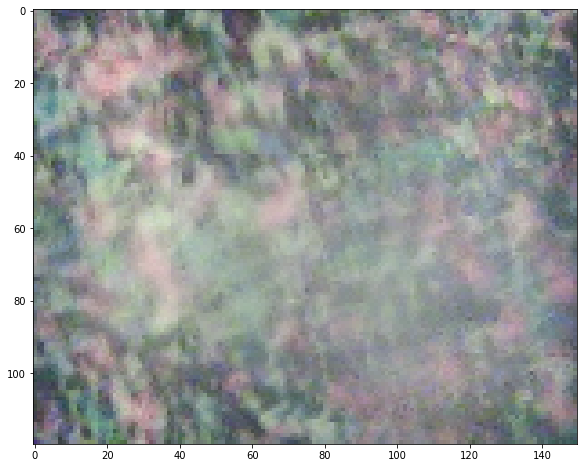

In [194]:
%matplotlib inline
row_stitched = []
for i in range(nrow):
    img_stitched_w = None
    for j in range(ncol):
#         if i == 0 && j == 0:
        if j == 0:
            img_stitched_w = img_array[i*ncol]
#             img_stitched_width = tile_list_histMatched[i*4+j]
            pass
        else:
            print(i*4 + j-1, i*4+ j)
            img1 =  img_array[i*ncol + j-1]#tile_list_histMatched[i*4 + j-1]
            img2 =  img_array[i*ncol + j] #tile_list_histMatched[i*4 + j]

            
            ov_pos = int(chosen_sol[i, j-1])
            print(ov_pos)
            ov1 = img1[:, -ov_pos:, :]
            ov2 = img2[:, :ov_pos, :]
            # stitch images with stacking
            img_stitched_w = stitch(img_stitched_w, img2, ov_pos, ov1, ov2,True, dim=1)
    row_stitched.append(img_stitched_w)

# print(row_stitched[0].astype(np.uint8).shape)
# # %matplotlib inline
# plt.figure(figsize=(10,12))
# plt.subplot(3,1,1)
# plt.imshow(row_stitched[0].astype(np.uint8), cmap='gray')
# plt.subplot(3,1,2)
# plt.imshow(row_stitched[1].astype(np.uint8))
# plt.subplot(3,1,3)
# plt.imshow(row_stitched[2].astype(np.uint8))
    

# print(row_stitched)
row_stitched = np.array(row_stitched)
print(row_stitched.shape)
t1=time.time()
corr_map_r = nb_generate_corr_map(row_stitched, nominal_ov = 65, bound_ov = 10, dim=0)
print(time.time() - t1)
print("corr_map_r",corr_map_r)
print("max corr", np.where(corr_map_r==max(corr_map_r[0])),np.where(corr_map_r==max(corr_map_r[1])))
range_ov_r = np.arange(65-10, 65+10 + 1)
print(range_ov_r)
NN = range(len(range_ov_r))
print("NN", NN)


prob2 = LpProblem('row stitching', LpMaximize)

rows_between = [1,2]
choose_var_r= LpVariable.dicts('choose', (rows_between, NN), 0, 1, cat='Integer')
chosen_value_r = LpVariable.dicts('chosen_val', rows_between, cat='Continuous')

prob2 += lpSum([chosen_value_r[i] for i in rows_between]), "cost function"

print(choose_var_r)

for i in rows_between:
    prob2 += chosen_value_r[i] == lpSum([corr_map_r[i-1, k]*choose_var_r[i][k] for k in NN])
    prob2 += lpSum([choose_var_r[i][k] for k in NN]) == 1

    
# fixed size constraint    
prob2 += lpSum([range_ov_r[l]*choose_var_r[i][l] for i in rows_between for l in NN]) == 120
    
t1 = time.time()
prob2.solve(solver)
print(time.time()-t1)

print([choose_var_r[i][l].varValue for l in NN])

chosen_sol_r = np.empty([nrow-1])
for i in rows_between:
    print(np.nonzero([choose_var_r[i][l].varValue for l in NN])[0] )

    chosen_sol_r[i-1] = range_ov_r[np.nonzero([choose_var_r[i][l].varValue for l in NN])[0] ]
print(chosen_sol_r)


# ========== 
all_stitched = []
for i in range(nrow):
#         if i == 0 && j == 0:
    if i == 0:
        all_stitched = row_stitched[0]
#             img_stitched_width = tile_list_histMatched[i*4+j]
        pass
    else:
#             print(i*4 + j-1)
        img1 =  row_stitched[i-1]#tile_list_histMatched[i*4 + j-1]
        img2 =  row_stitched[i] #tile_list_histMatched[i*4 + j]
        print(img1.shape, img2.shape)
#             time.sleep(0.1)
#             plt.figure()
#             plt.subplot(1,2,1)
#             plt.imshow(img1)
#             plt.axis('off')
#             plt.subplot(1,2,2)
#             plt.imshow(img2)
#             plt.axis('off')

        ov_pos = int(chosen_sol_r[i-1])
        ov1 = img1[-ov_pos:, :, :]
        ov2 = img2[:ov_pos, :, :]
        # stitch images with stacking
        all_stitched = stitch(all_stitched, img2, ov_pos, ov1, ov2, dim=0)

print(all_stitched.shape)

%matplotlib inline
plt.figure(figsize=(10,8))
plt.imshow(all_stitched.astype(np.uint8))